In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import time  
import datetime
from datetime import timedelta

In [ ]:
activity = pd.read_csv("1_Activity.csv",sep = ';',na_values = ['NULL'],parse_dates =['date'])
activity_category = pd.read_csv("2_Activity_Category.csv",sep = ';',na_values = ['NULL'],dtype = {'MET':float}, encoding = "ISO-8859-1")
metric = pd.read_csv("6_Metric.csv",sep = ';',na_values = ['NULL'],  dtype = {'user_id': int, 'value': float}, parse_dates=['date'])
cohorte = pd.read_csv("cohortes.csv", sep= ';', na_values = ['NULL'], dtype = {'user_id': int, 'value': float})

date_parser = pd.to_datetime

In [ ]:
metric = metric.drop(['id', 'deletedAt','createdAt', 'updatedAt'], axis=1)
cohorte = cohorte.drop(['gender','height','weight','deletedAt', 'createdAt', 'updatedAt', 'Unnamed: 9'], axis=1)
cohorte = cohorte.rename(columns = {"id" : "customer_id"})

activity = activity[activity['state'] == "done"]
activity = activity[['customer_id','category_id','date','duration']]

activity_category = activity_category[['id','MET']]

# Calcul de l'évolution du nombre de pas en fonction du temps

Tout d'abord on commence par creer un nouveau DataFrame qui va contenir toutes les lignes où les utlisateurs marchent ou courent (category_id vaut 5, 6 ou 7).
Ensuite, on enlève la colonne des categories, puisqu'elle nous est inutile, et on enlève tous les doublons.
Enfin, on fait une jointure entre la table contenant les pas et les dates des differentes activités, et la table contenant le numero de cohorte de chaque utilisateur. La jointure se fait donc sur l'attribut commun du "user_id". On fait un "outer merge" pour que les utilisateurs présents dans les deux tableaux soient présents dans le tableau final. Ceci a pour effet de prendre en compte les utilisateurs qui auraient été affectés à une cohorte, mais qui n'auraient pas fourni de données sur le nombre de pas qu'ils ont effectués.

In [0]:
pas = metric[metric['category_id'].isin([5,6,7])]
pas = pas.drop('category_id', axis = 1)
pas = pas.drop_duplicates()

df_merged = pd.merge(pas ,cohorte, how = 'outer', on = 'user_id')


## Analyse temporelle

Tout d'abord, on va parcourir le DataFrame en fonction des cohortes (disease). Pour chaque cohorte, on crée un DataFrame temporaire, noté df_temp, qui est ensuite trié par date du plus vieux au plus récent. Après une initialisation de certaines variables (on notera que le nombre n correspond au nombre de personnes présente au sein d'une cohorte, qu'elle ait participé ou non au nombre total de pas), on parcours ce DataFrame temporaire pour remplir une liste (somme_pas) correspondant à la moyenne de la somme cumulée totale de pas à une date donnée, et une autre (x) correspondant à la difference de jours entre le début de l'activité de la cohorte.
Ces deux listes sont ensuite tracées l'une en fonction de l'autre pour obtenir les graphiques ci-dessous.

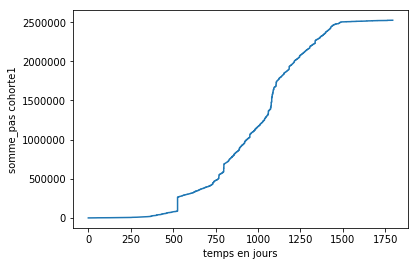

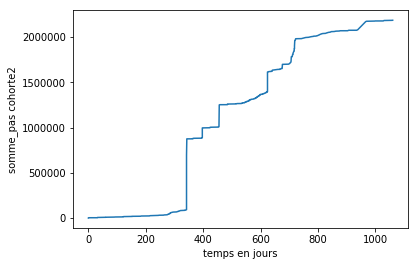

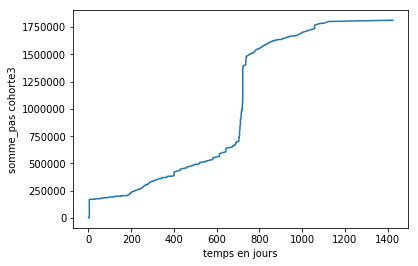

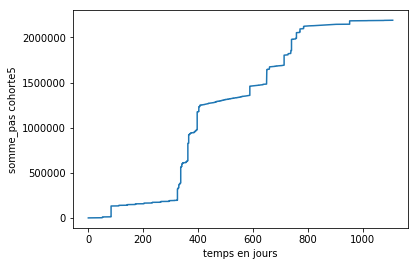

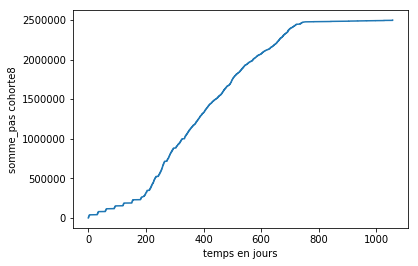

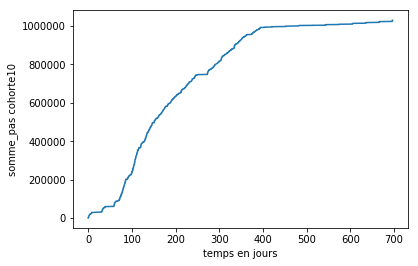

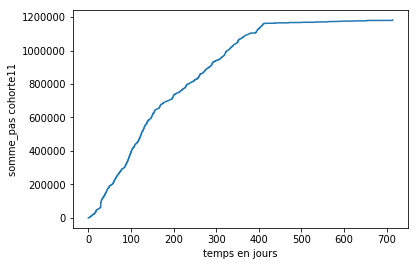

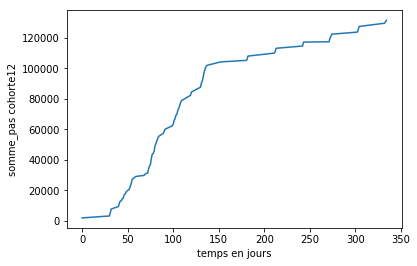

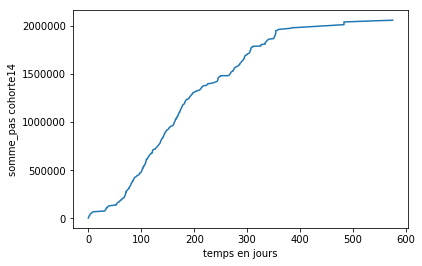

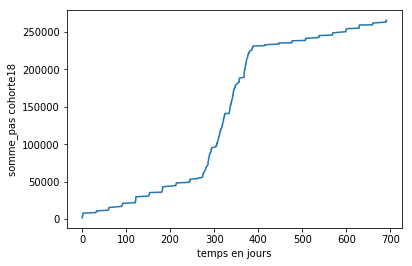

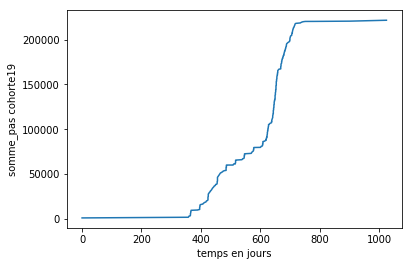

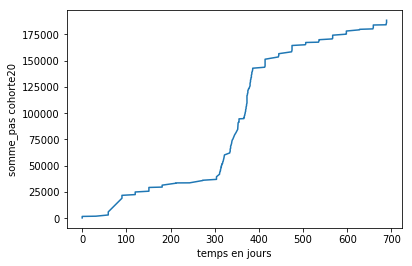

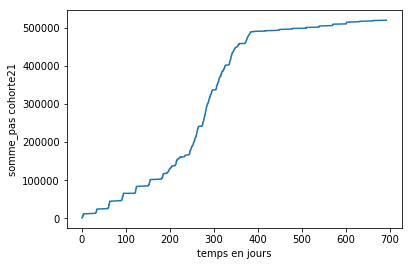

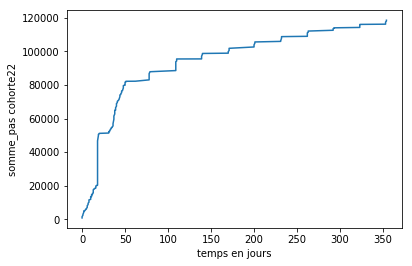

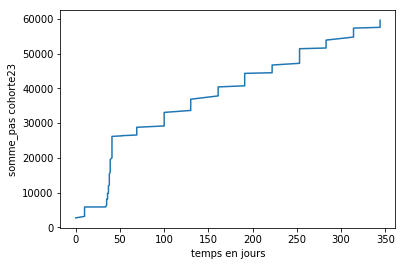

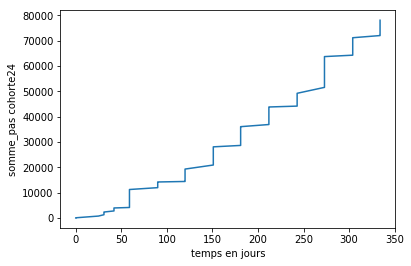

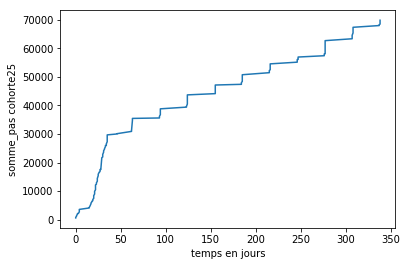

In [0]:
disease = list(set(df_merged['disease_id']))

sum_value = 0

for i in disease:
    df_temp = df_merged[df_merged['disease_id'].isin([i])]
    df_temp = df_temp.sort_values(by=['date'])
    df_temp = df_temp.reset_index(drop=True)
    date_min = min(df_temp['date'])
    l = df_temp.shape[0]
    n = len(list(set(df_temp['user_id'])))
    sum_value = 0
    date_abcisse = 0
    somme_pas = []
    x = []
    for j in range(0,l):
        sum_value += df_temp['value'][j]
        date_abcisse=  (df_temp['date'][j]-date_min).days
        somme_pas.append(sum_value/n)
        x.append(date_abcisse)
    plt.plot(x, somme_pas)
    plt.xlabel('temps en jours')
    plt.ylabel('somme_pas cohorte' + str(i))
    plt.show()

# Calcul de l'évolution des MET en fonction du temps

Pour les MET, les utilisateurs doivent rentrer eux-mêmes les activités qu'ils ont réalisés. Certains utilsiateurs n'ont rien rempli, on est donc face à une ambigüitée : les utilisateurs qui n'ont rien rempli n'ont-ils rien fait ou bien ont-ils oubliés de le rentrer ? 
Plusieurs traitements sont donc possibles, ici nous n'allons pas tenir des compte des utilisateurs qui n'ont rien remplis. Nous faisons donc l'hypothèse qu'ils ont réalisés le même nombre de MET que la moyenne et qu'ils ont oubliés de les rentrer. 

## Préliminaires

On ré-organise les donnés pour avoir un tableau qui récapitule toutes les informations dont on a besoin. Dans activity on commence par prendre seulement les lignes où les activités ont été faites. Ensuite on supprime certaines colonnes qui ne serviront à rien. De même dans activity_category où on ne prend que les colonnes qui nous seront utiles.

In [0]:
#De même que pour le calcul du KPI, on travaille la donné pour la mettre sous la forme d'un unique tableau sur lequel on travaillera

df = activity.merge(activity_category, left_on = 'category_id', right_on = 'id', how = 'inner')

df = df[['customer_id','duration','MET','date']]
    
df = df.assign(value = lambda df: df.duration*df.MET)
df = df[['customer_id','value','date']]
df.sort_values(by = 'customer_id')
df = df[df['value'] != 0]
du = df.merge(cohorte ,left_on = 'customer_id', right_on = 'customer_id')

du = du[['customer_id','value','date','disease_id']]

## Traitement spécifique à l'évolution temporelle 

In [0]:
cohorte_list = list(set(du['disease_id']))

In [0]:
print(cohorte_list )

[1, 2, 3, 5, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 25]


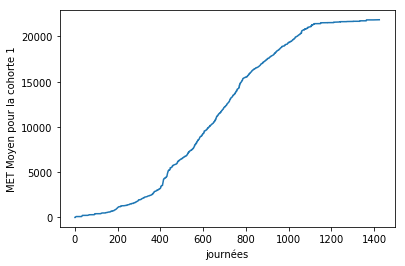

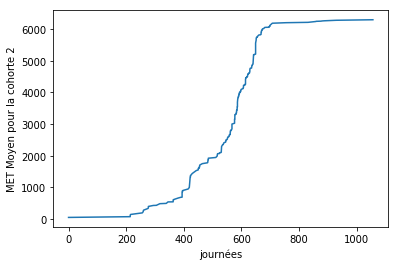

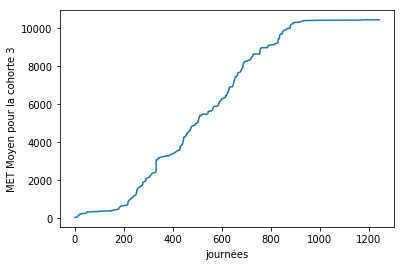

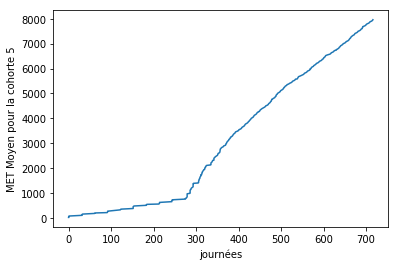

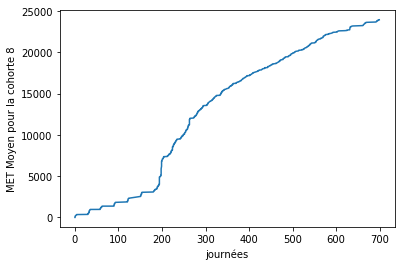

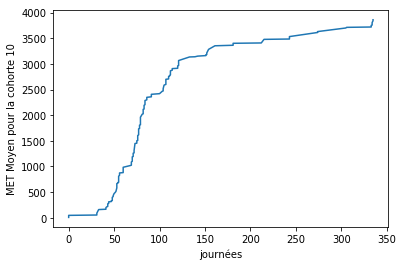

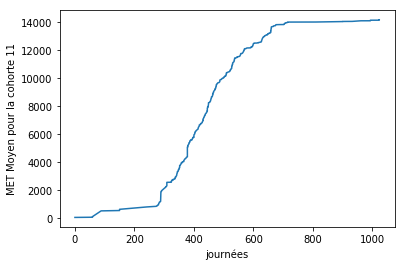

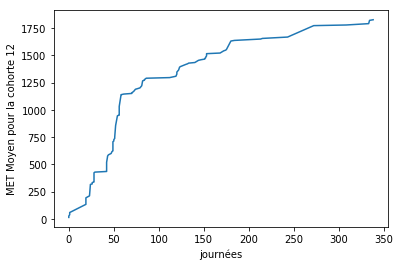

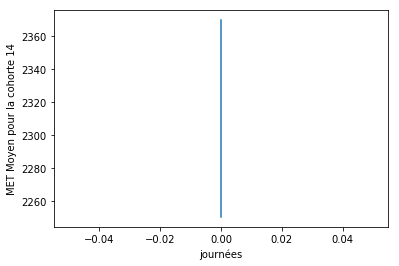

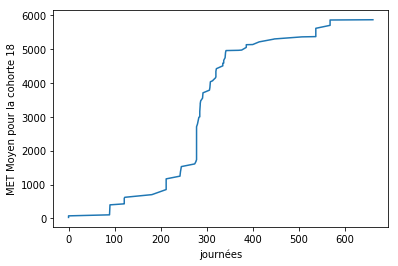

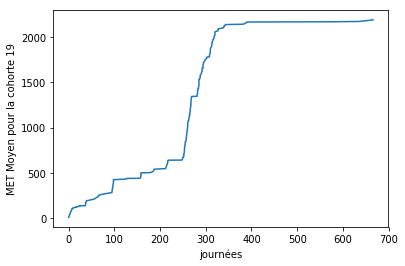

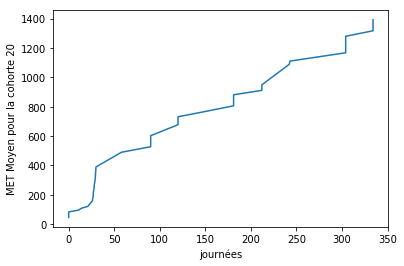

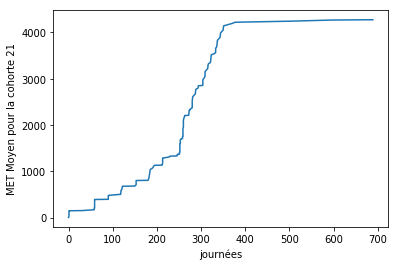

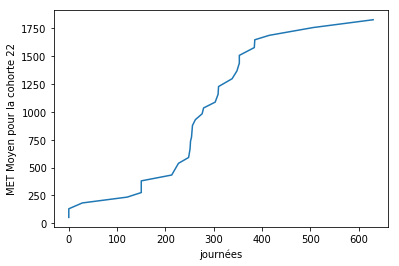

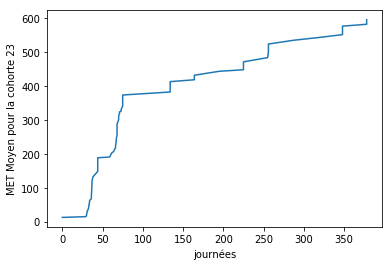

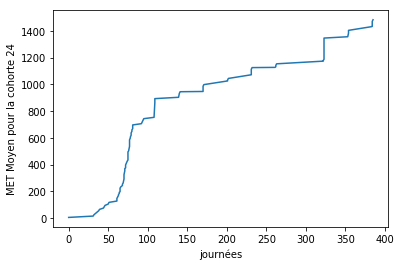

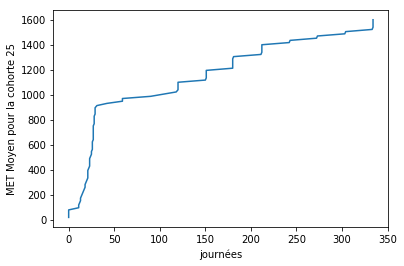

In [0]:
# On crée une liste comportant tout les numéros de cohortes utiles pour les MET
cohorte_list = list(set(du['disease_id']))

for i in cohorte_list :
    #On crée une liste contenant les informations de la cohorte i 
    du_temp = du[du['disease_id'].isin([i])]
    #On trie par date et on réindex
    du_temp = du_temp.sort_values(by = ['date'])
    du_temp = du_temp.reset_index(drop = True)
    #On détermine les adtes de fin et de début
    date_debut_float = du_temp.loc[0,'date']
    l = du_temp.shape[0]
    date_fin_float = du_temp.loc[l-1,'date']
    #On crée notre liste des temps : elle part de 0 et contient tout les temps où la cohorte a réalise une activité
    x  = [0]
    for j in range (1,l) :
        delta = (du_temp.loc[j,'date'] - du_temp.loc[0,'date']).days
        x.append(delta)
   #On crée la liste des MET
    y = []    
    #Le nombre de personne dans la cohorte i 
    n = len(list(set(du_temp['customer_id'])))
    #Pour chaque fois où une activité est réalisé, on calcul le nombre de MET total réalisé par la cohorte qu'on divise par le nombre d'individus pour obtenir le nombre moyen de MET réalisé par un individu sur la période
    for j in range (0,l):
         y.append(sum(du_temp.loc[0:j,'value'])/n)
    #On trace l'évolution
    plt.plot(x,y)
    plt.xlabel('journées')
    plt.ylabel('MET Moyen pour la cohorte '+ str(i))
    plt.show()

# Calcul de l'évolution des leçons en fonction du temps

La fonction get_global_df permet d'extraire les données utiles du tableau global et de nettoyer les données. L'input est les Dataframe du tableau global et du Customer_Lesson. L'output est un Dataframe.

In [13]:
def get_global_df(group_df, lesson_df):
    lesson_df = lesson_df.drop(['id'], axis=1)
    global_df = pd.merge(group_df, lesson_df, how='outer', on='customer_id')
    global_df['date'] = pd.to_datetime(global_df['date'],infer_datetime_format=True).dt.normalize()
    global_df = global_df[global_df['date']<'2019-03-01']
    return global_df

La fonction analyse_temp permet de calculer les KPI leçon pour les différentes périodes. L'input est un Dataframe de données, le numéro de cohorte et le nombre de période que nous voulons. L'output est un Dataframe.

In [14]:
def analyse_temp(input_df, disease_id, section_number):
    # calculation of KPI moyen for different periods
    # disease_id: cohorte munber, section_number: the number of section
    group_df = input_df.loc[input_df['disease_id'] == disease_id]
    date_begin = pd.to_datetime(min(group_df['date']))
    date_end = pd.to_datetime(max(group_df['date']))
    day_difference = date_end - date_begin
    section = day_difference/section_number
    date_list = []
    for i in range(1, section_number+1):
        date_list.append(date_begin + i * section)
    section_df_list = []
    for date in date_list:
        group_section_df = group_df.loc[pd.to_datetime(group_df['date']) < pd.to_datetime(date)]
        section_df_list.append(group_section_df)
    # calculate the KPI for the different dates in date list
    KPI_temps_dic = {}
    for i in range(len(section_df_list)):
        KPI_temps_key = date_list[i]
        lesson_done_df = section_df_list[i].loc[section_df_list[i]['state'] == 'done']
        KPI_temps_value = len(lesson_done_df)/len(section_df_list[i])
        KPI_temps_dic[KPI_temps_key] = KPI_temps_value
    # put the KPI in dataframe
    date_list = list(KPI_temps_dic.keys())
    time_list = []
    for date in date_list:
        time_diff = (date - date_begin).days
        time_list.append(time_diff)
    col_KPI_lesson = []
    for i in date_list:
        col_KPI_lesson.append(KPI_temps_dic[i])
    d = {'Temps':time_list, 'KPI':col_KPI_lesson}
    KPI_temps_df = pd.DataFrame(data=d)
    return KPI_temps_df

La fonction visual permet de visualiser l'évolution temporelle de KPI leçon de chaque cohorte. L'input est un Dataframe de données, le nom d'axe Y, et le numéro de cohorte.  

In [15]:
def visual(input_df, y_label, cohorte_num):
    input_df.plot(kind='line', x='Temps', y='KPI', linestyle='-', title='KPI Lesson for cohorte '+str(cohorte_num))
    plt.xlabel('temps en jours')
    plt.ylabel(y_label)
    # plt.grid(True)
    plt.show()

Présentation d'évolution temporelle de KPI leçon de chaque cohorte.  

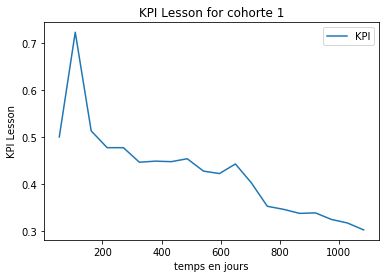

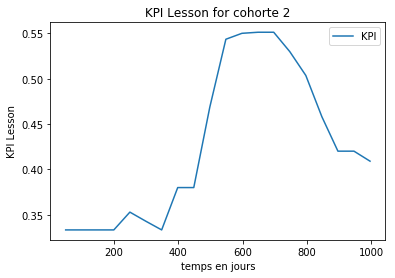

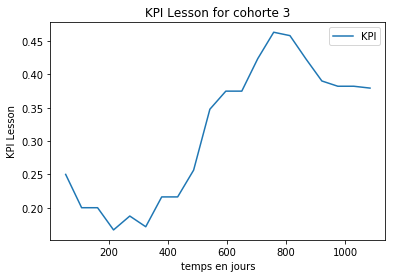

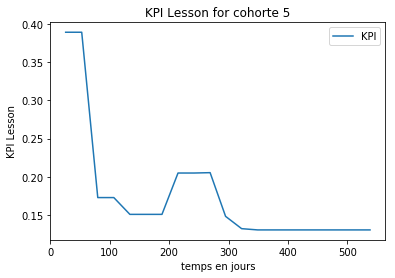

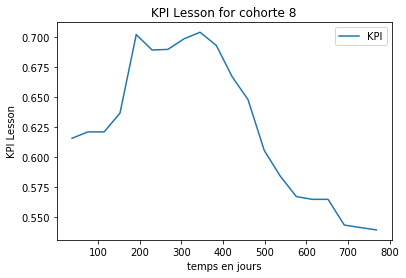

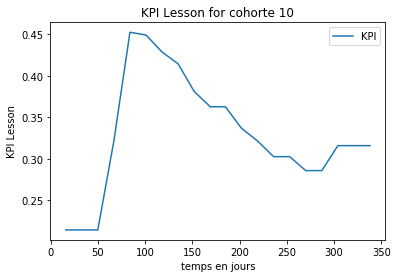

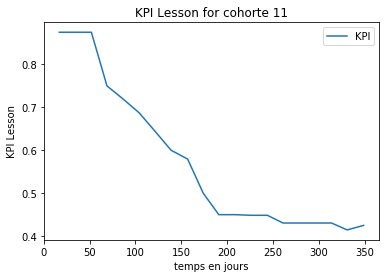

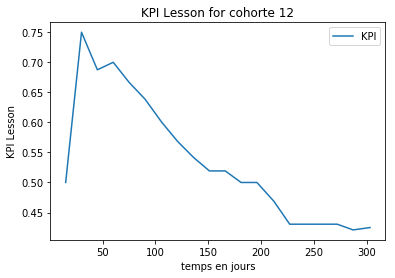

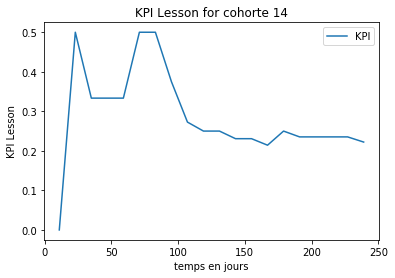

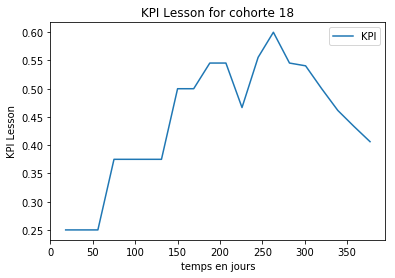

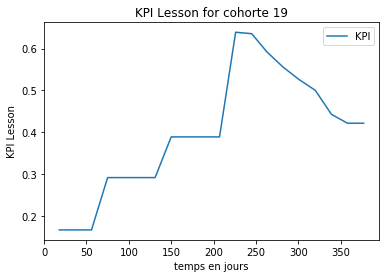

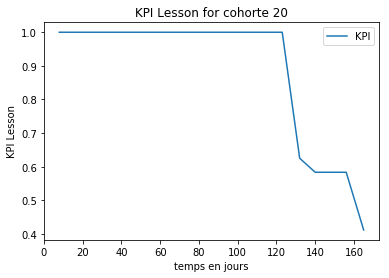

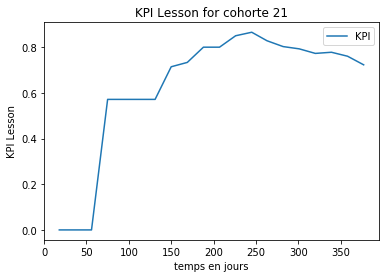

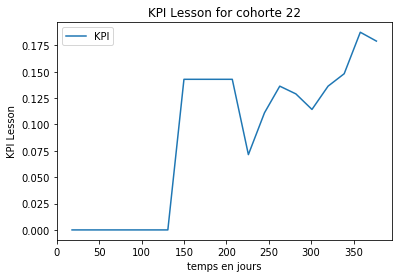

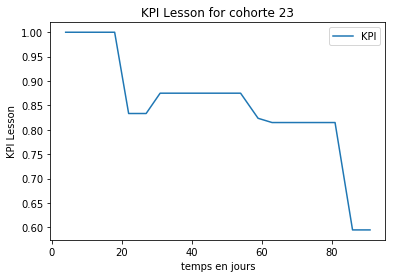

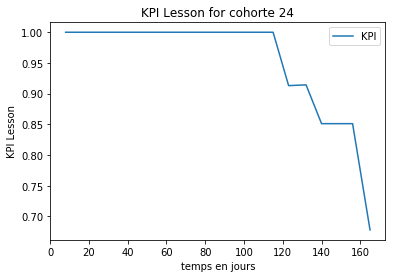

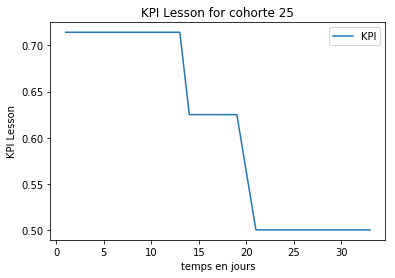

In [24]:
section_number = 20
global_df = pd.read_csv('./KPI_lesson_global.csv', encoding='UTF-8')

for i in range(1, 26):
    try:
        KPI_temps_df = analyse_temp(global_df, i, section_number)
        visual(KPI_temps_df, 'KPI Lesson', i)
    except:
        continue